In [1]:
import sys
sys.path.append("/data0/cly/spectralGan/GAN-collections/")
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from scipy.interpolate import griddata
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import radialProfile, glob, cv2

import matplotlib as mpl
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

from matplotlib.font_manager import _rebuild
_rebuild()


class dataset_draw(object):
    def __init__(self, folderList, labelList, inputSize = 128, outputSize = 88, maxIter = 2000, savePath = None, 
                 title = None, xlabel = None, ylabel = None, bias = None, align = False):
        self.y = []
        self.rgb_weights = [0.2989, 0.5870, 0.1140]

        self.number_iter = maxIter
        self.N = outputSize
        self.input_size = inputSize
        
        self.folder_list = folderList
        self.label_list = labelList
        self.savepath = savePath
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.bias = bias
        self.align = align
                
    def get_psd1D(self, folder):
        psd1D_total = np.zeros([self.number_iter, self.N])
        psd1D_org_mean = np.zeros(self.N)
        cnt = 0
        
        for filename in glob.glob(folder):
            img = cv2.imread(filename, 0)
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            fshift += 1e-8
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
            psd1D_total[cnt,:] = psd1D  
            cnt += 1
            if cnt == self.number_iter:
                break

        for x in range(self.N):
            psd1D_org_mean[x] = np.mean(psd1D_total[:,x])

        return psd1D_org_mean

    def draw(self):
        
        for f in self.folder_list:
            mean = self.get_psd1D(folder=f)
            self.y.append(mean)
            
        x = np.arange(0, self.N, 1)
        _, ax = plt.subplots(figsize=(20,14))
        
        if self.align:
            for index in range(len(self.y)):
                if index == 0: continue
                self.y[index] -= (self.y[index][0] - self.y[0][0])
        
        if self.bias:
            for index, b in enumerate(self.bias):
                self.y[index] += b
        
        for index, label in enumerate(self.label_list):
            ax.plot(x, self.y[index], alpha=0.75, label=label, linewidth=6.0)


        
        if self.title:
            plt.title(self.title, fontsize=40)
        if self.xlabel:
            plt.xlabel('频率', fontsize=30)
        if self.ylabel:
            plt.ylabel('功率谱密度', fontsize=30)
        plt.tick_params(axis='x', labelsize=30)
        plt.tick_params(axis='y', labelsize=30)
        plt.grid(True)
        ax.legend(loc='best', prop={'size': 30})
        ax.patch.set_facecolor("gray")
        ax.patch.set_alpha(0.1)
        for i in ['top', 'bottom', 'left', 'right']:
            ax.spines[i].set_visible(False)
        
        if self.savepath:
            plt.savefig(self.savepath)
        plt.show()

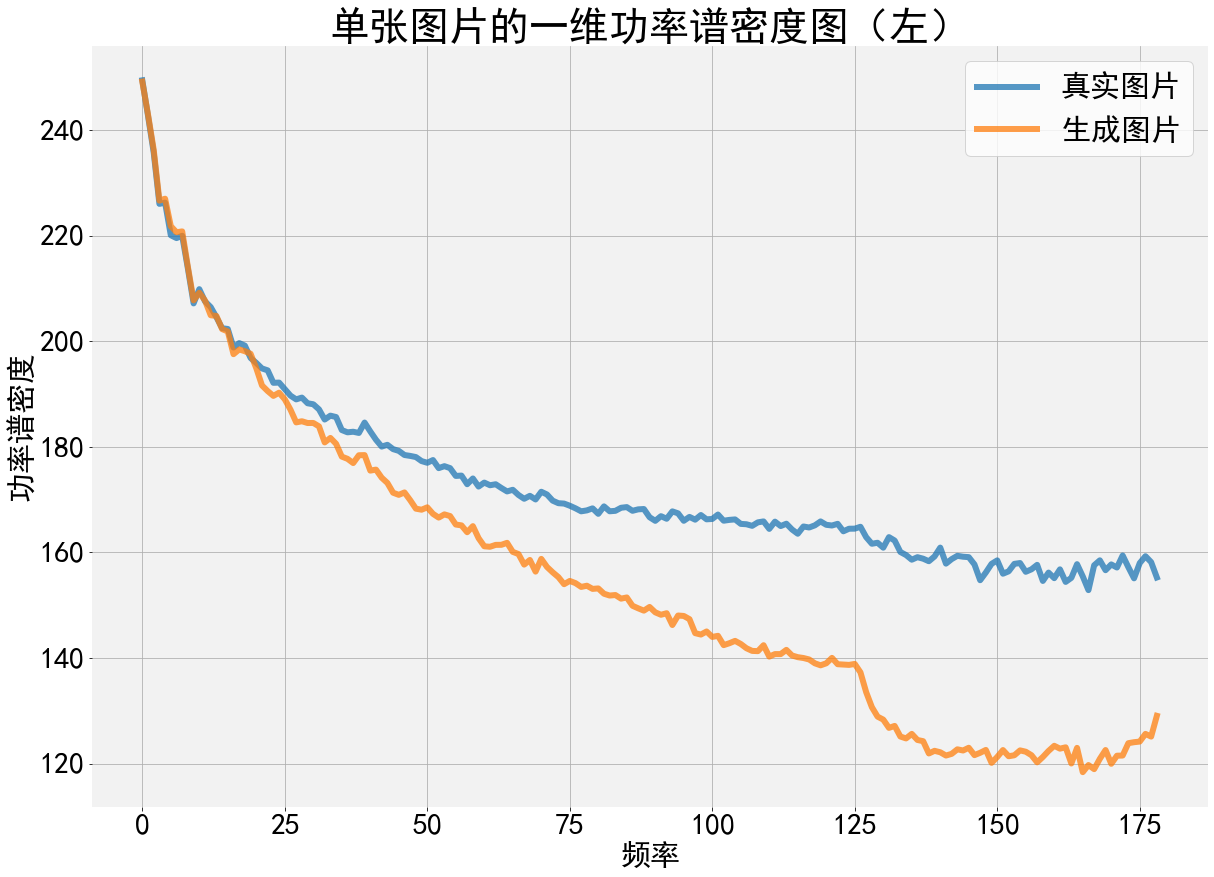

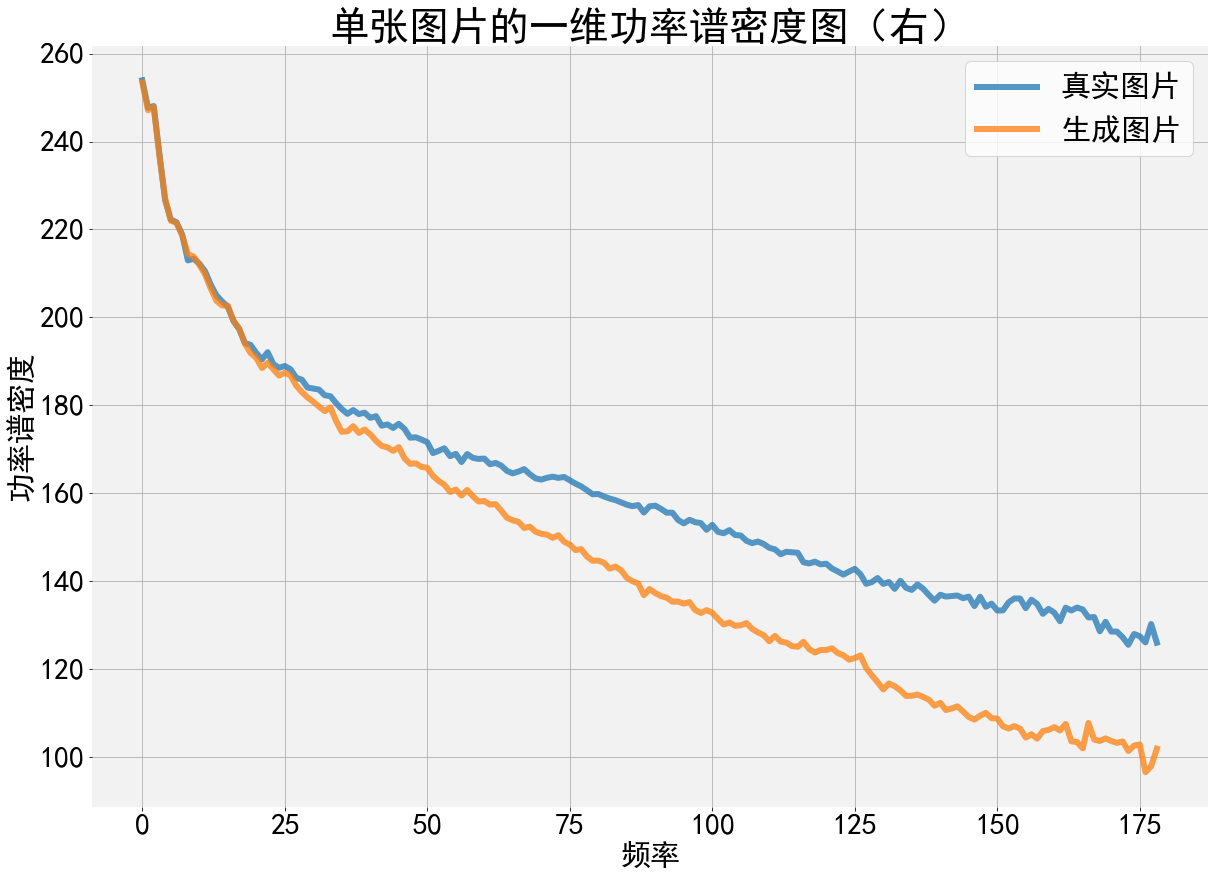

In [7]:
folderList = ["../PDCAT/Real.jpg", "../PDCAT/Inversion.jpg"]
labelList = ["真实图片", "生成图片"]
singlePSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 256, outputSize = 179, maxIter = 1, 
             savePath = "../毕业论文/单张图片的一维功率谱密度图（左）.pdf", title = "单张图片的一维功率谱密度图（左）",
             xlabel = "频率", ylabel = "Power 功率谱密度")
singlePSD.draw()

folderList_2 = ["../PDCAT/1.jpg", "../PDCAT/2.jpg"]
singlePSD_2 = dataset_draw(folderList = folderList_2, labelList = labelList, inputSize = 256, outputSize = 179, maxIter = 1, 
             savePath = "../毕业论文/单张图片的一维功率谱密度图（右）.pdf", title = "单张图片的一维功率谱密度图（右）",
             xlabel = "频率", ylabel = "Power 功率谱密度")
singlePSD_2.draw()

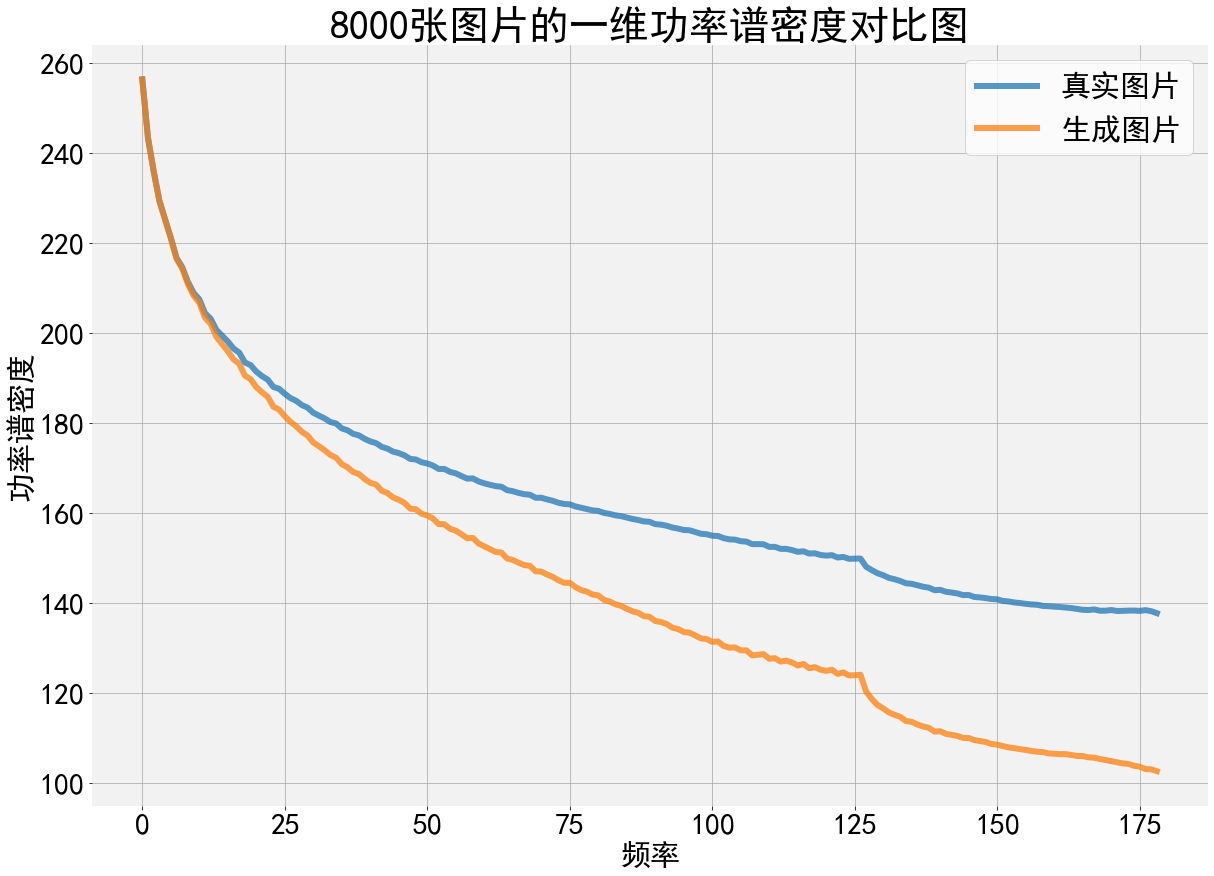

In [14]:
folderList = [
            '/home/zhangdongyu/mganprior/inversion_input/*',
            '/home/zhangdongyu/mganprior/inversion_output/*'
            ]
labelList = ["真实图片", "生成图片"]
ResizeConvPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 256, outputSize = 179, maxIter = 500, 
                             savePath = "../毕业论文/8000张图片的一维功率谱密度对比图.pdf", title = "8000张图片的一维功率谱密度对比图",
                             xlabel = "频率", ylabel = "功率谱密度")
ResizeConvPSD.draw()

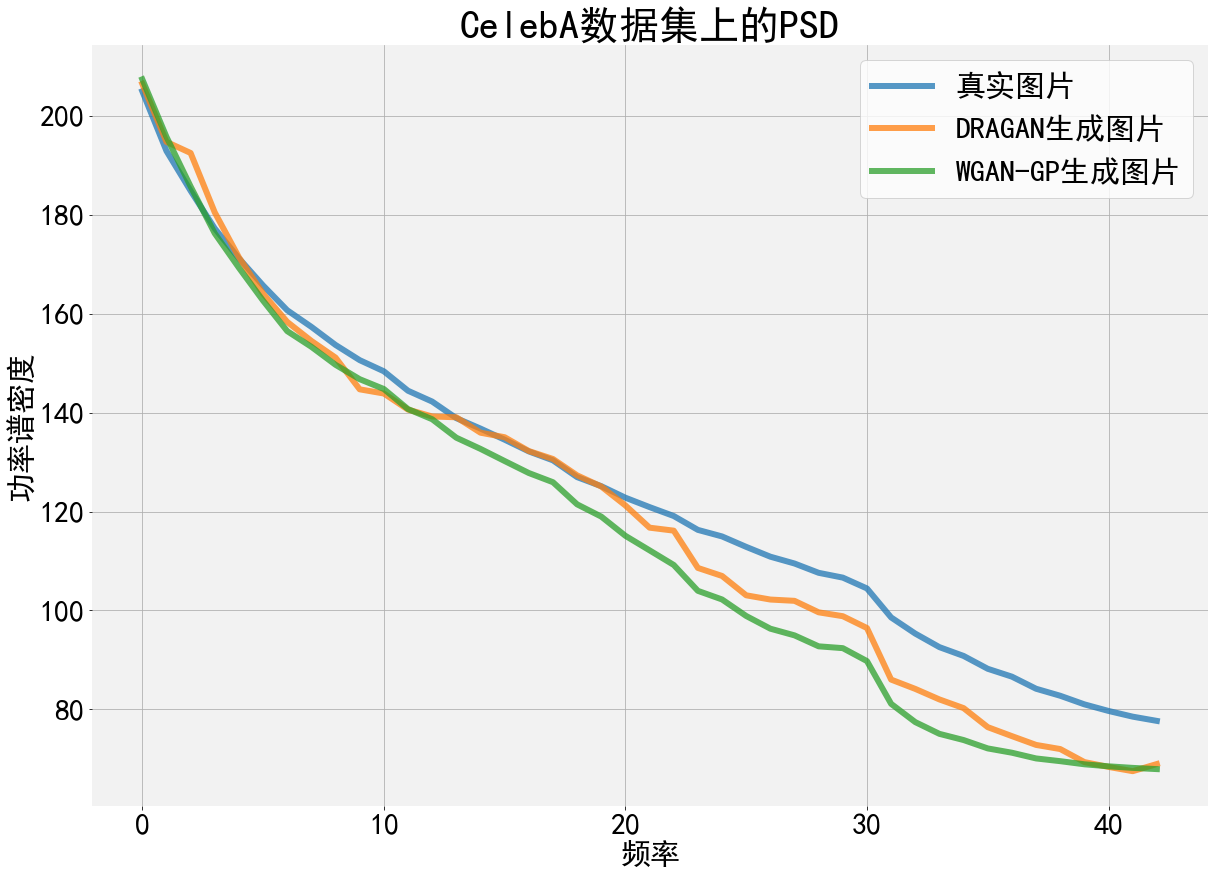

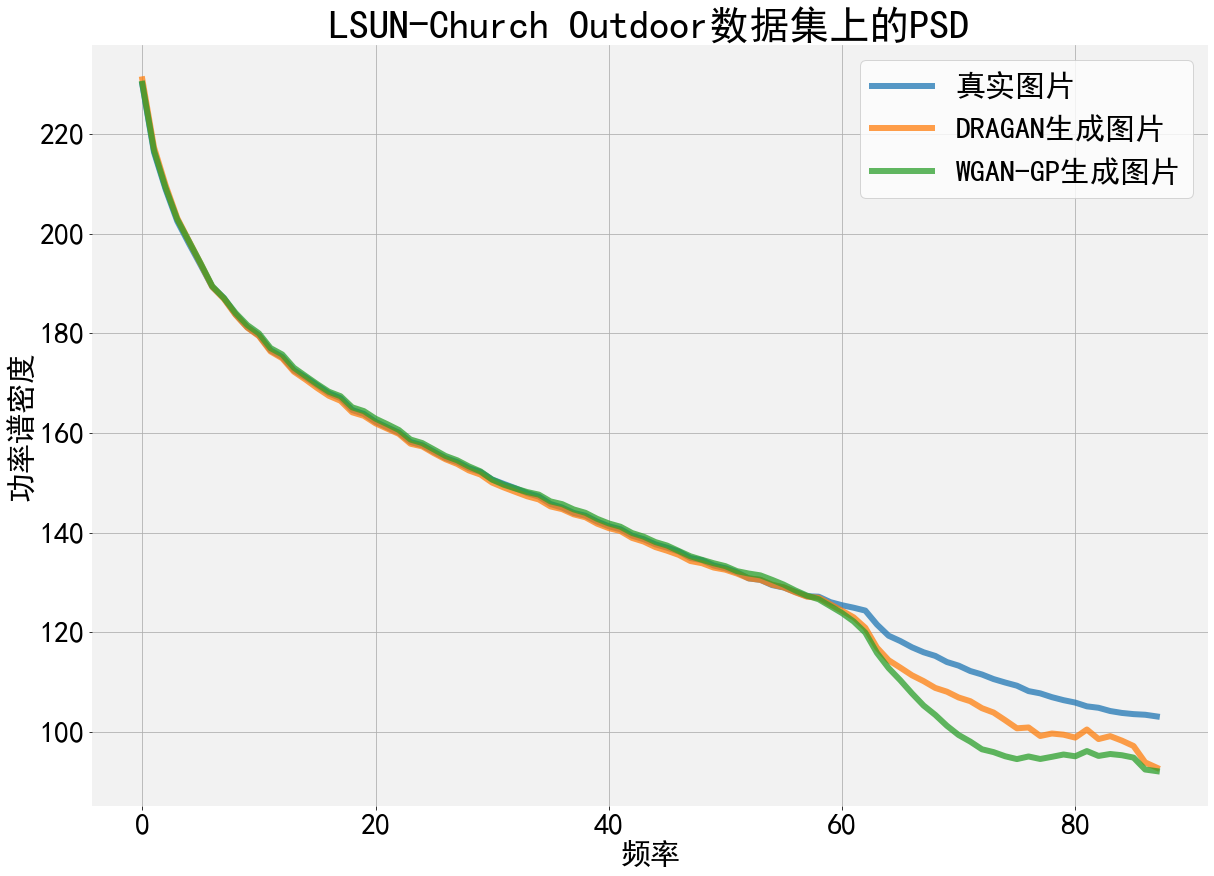

In [16]:
folderlist1 =   ['../data/celeba/celeba64/*',
                '../results/unshift/celeba/DRAGAN_64_50_evaluate/*',
                '../results/unshift/celeba/WGAN_GP_64_50_evaluate/*']
folderList2 = [
            '../data/lsun/church_outdoor128/*',
            '../results/unshift/lsun-church_outdoor/DRAGAN_128_50_evaluate/*',
            '../results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*'
            ]
labelList = ["真实图片", "DRAGAN生成图片", "WGAN-GP生成图片"]

CelebAPSD = dataset_draw(folderList = folderlist1, labelList = labelList, inputSize = 64, outputSize = 43, maxIter = 8000, 
                             savePath = "../毕业论文/CelebaPSD.pdf", title = "CelebA数据集上的PSD",
                             xlabel = "频率", ylabel = "功率谱密度")

ChurchPSD =  dataset_draw(folderList = folderList2, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 8000, 
                             savePath = "../毕业论文/ChurchPSD.pdf", title = "LSUN-Church Outdoor数据集上的PSD",
                             xlabel = "频率", ylabel = "功率谱密度")

CelebAPSD.draw()
ChurchPSD.draw()

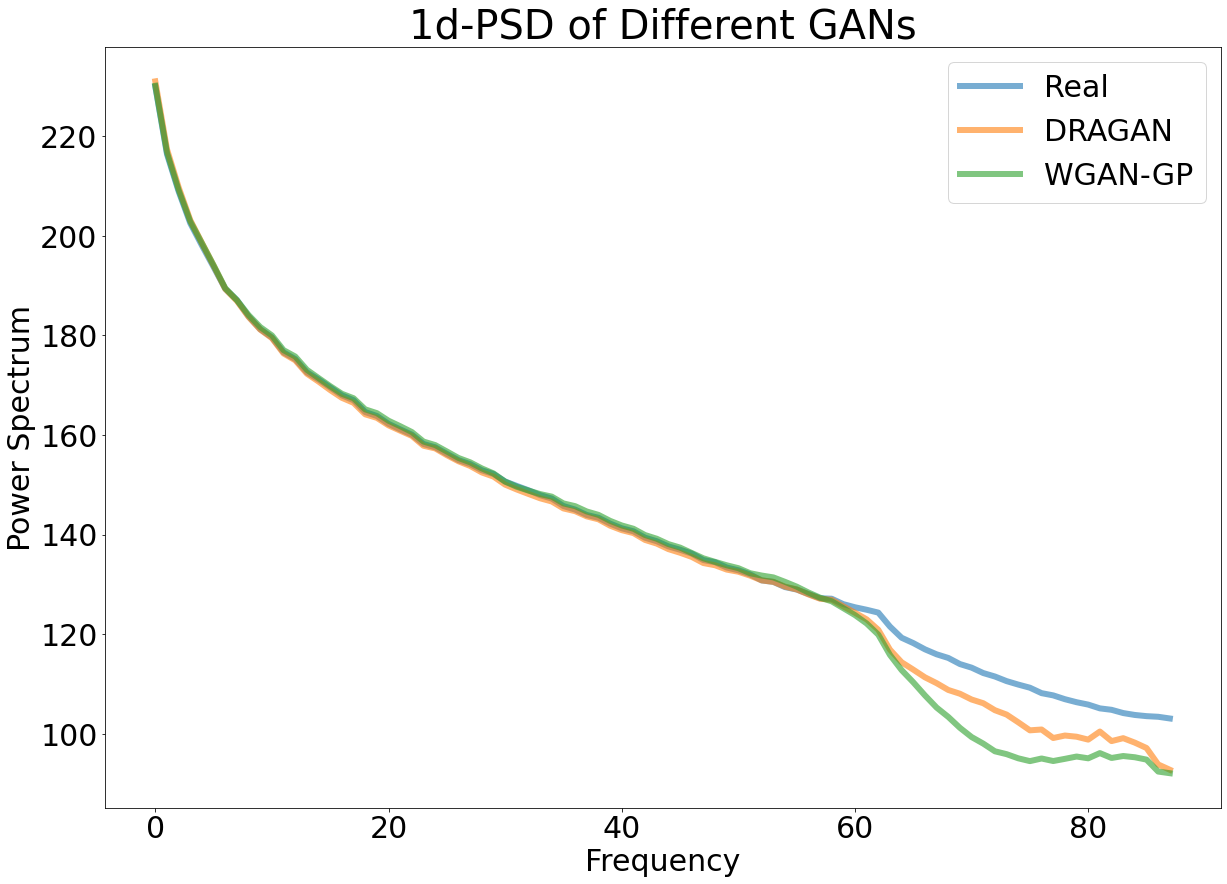

In [21]:
folderList = [
            '../data/lsun/church_outdoor128/*',
            '../results/unshift/lsun-church_outdoor/DRAGAN_128_50_evaluate/*',
            '../results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*'
            ]
labelList = ["Real", "DRAGAN", "WGAN-GP"]
ResizeConvPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 8000, 
                             savePath = "../PDCAT/ResizeConvPSD.pdf", title = "1d-PSD of Different GANs",
                             xlabel = "Frequency", ylabel = "Power Spectrum")
ResizeConvPSD.draw()

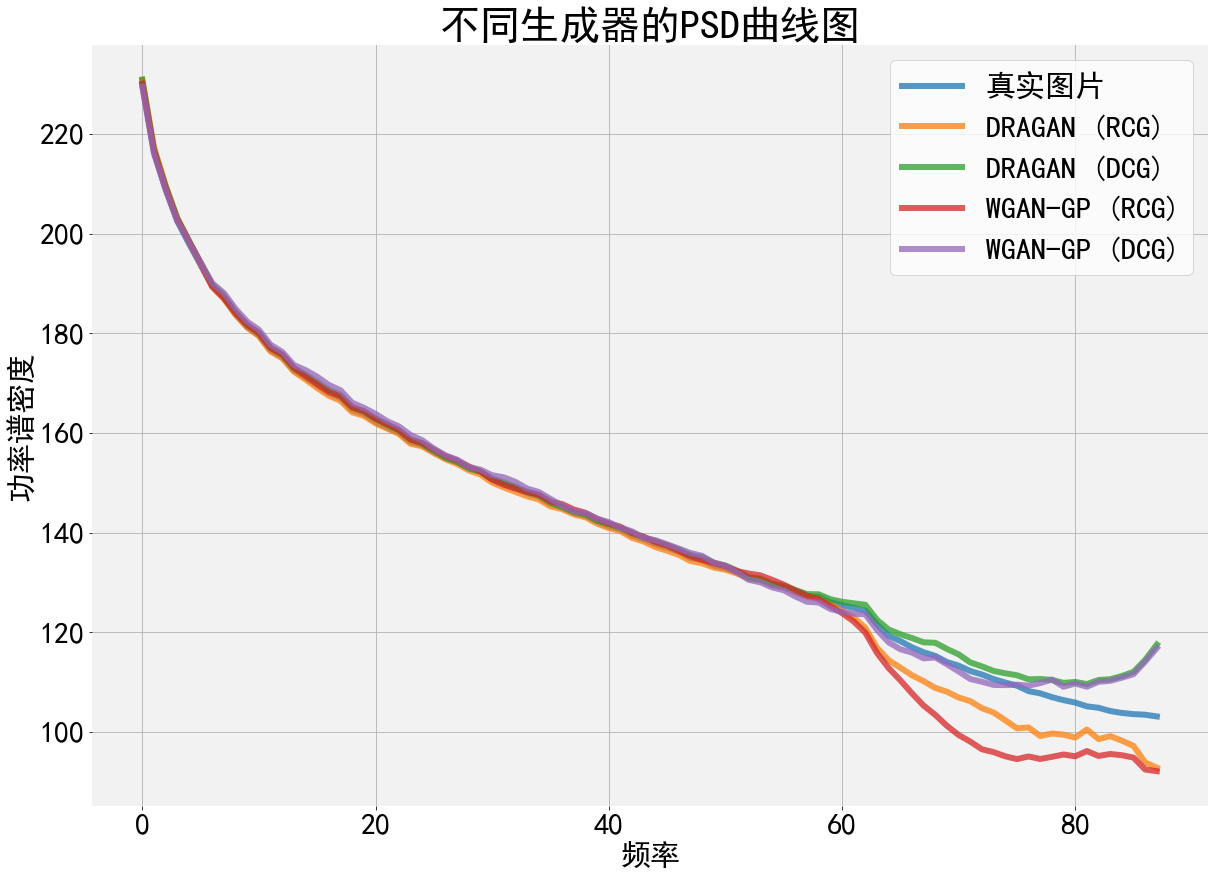

In [5]:
folderList = [
            '../data/lsun/church_outdoor128/*',
            '../results/unshift/lsun-church_outdoor/DRAGAN_128_50_evaluate/*',
            '../results_deconv/unshift/lsun-church_outdoor/DRAGAN_128_100_evaluate/*',
            '../results/unshift/lsun-church_outdoor/WGAN_GP_128_50_evaluate/*',
            '../results_deconv/unshift/lsun-church_outdoor/WGAN_GP_128_100_evaluate/*'
            ]
labelList = ["真实图片", "DRAGAN (RCG)", "DRAGAN (DCG)", "WGAN-GP (RCG)", "WGAN-GP (DCG)"]
DeconvPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 8000, 
                             savePath = "../毕业论文/不同生成器的PSD曲线图.pdf", title = "不同生成器的PSD曲线图",
                             xlabel = "频率", ylabel = "功率谱密度")
DeconvPSD.draw()

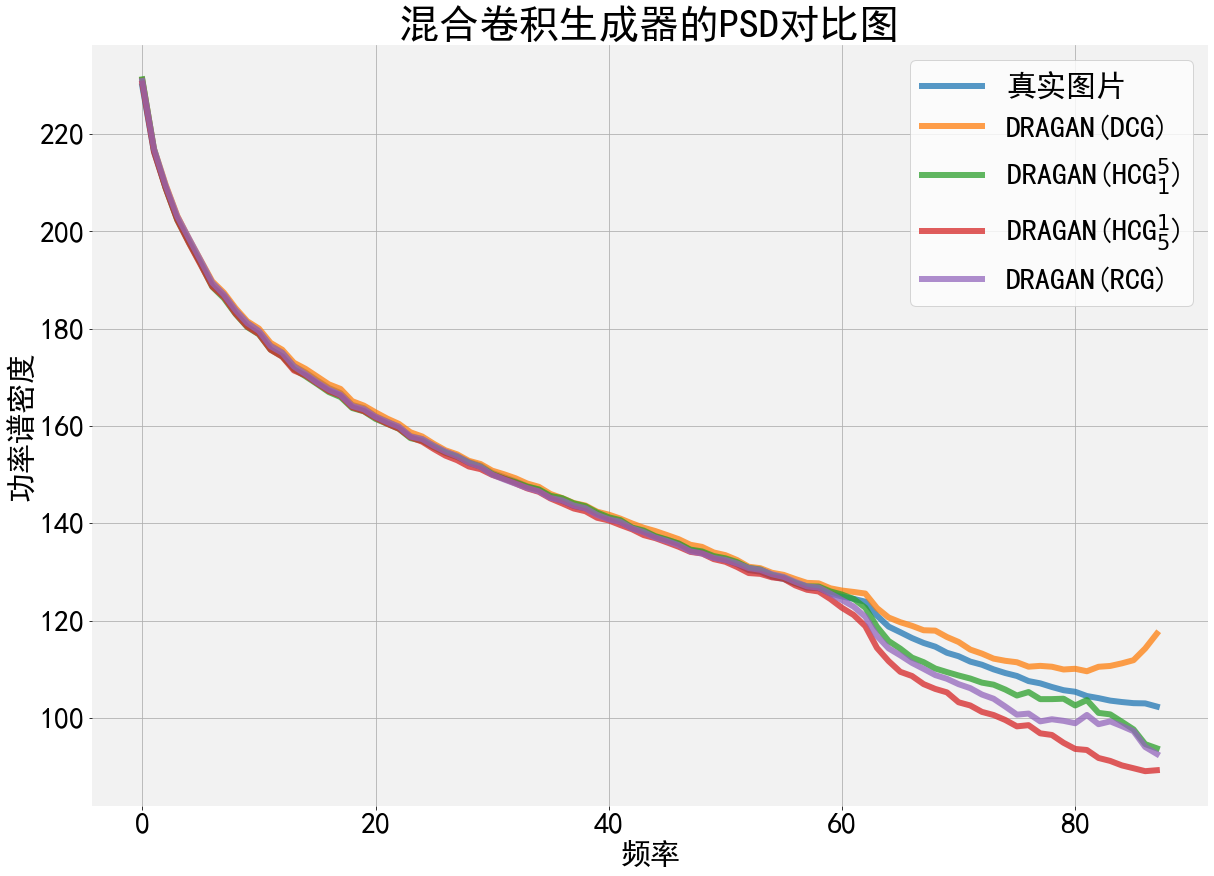

In [11]:
folderList = [
            '../data/lsun/church_outdoor128/*',
            '../results_deconv/unshift/lsun-church_outdoor/DRAGAN_128_100_evaluate/*',
            '../results_sup/resize/lsun-church_outdoor/DRAGAN_128_100_evaluate/*',
            '../results_sup/lsun-church_outdoor/DRAGAN_128_50_evaluate/*',
            '../results/unshift/lsun-church_outdoor/DRAGAN_128_50_evaluate/*'
            ]
labelList = [
            '真实图片',
            'DRAGAN(DCG)',
            'DRAGAN(HCG$^5_1$)',
            'DRAGAN(HCG$^1_5$)', 
            'DRAGAN(RCG)'
            ]    
HybridPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 800, 
                             savePath = "../毕业论文/HCGPSD.pdf", title = "混合卷积生成器的PSD对比图",
                             xlabel = "频率", ylabel = "功率谱密度")
HybridPSD.draw()

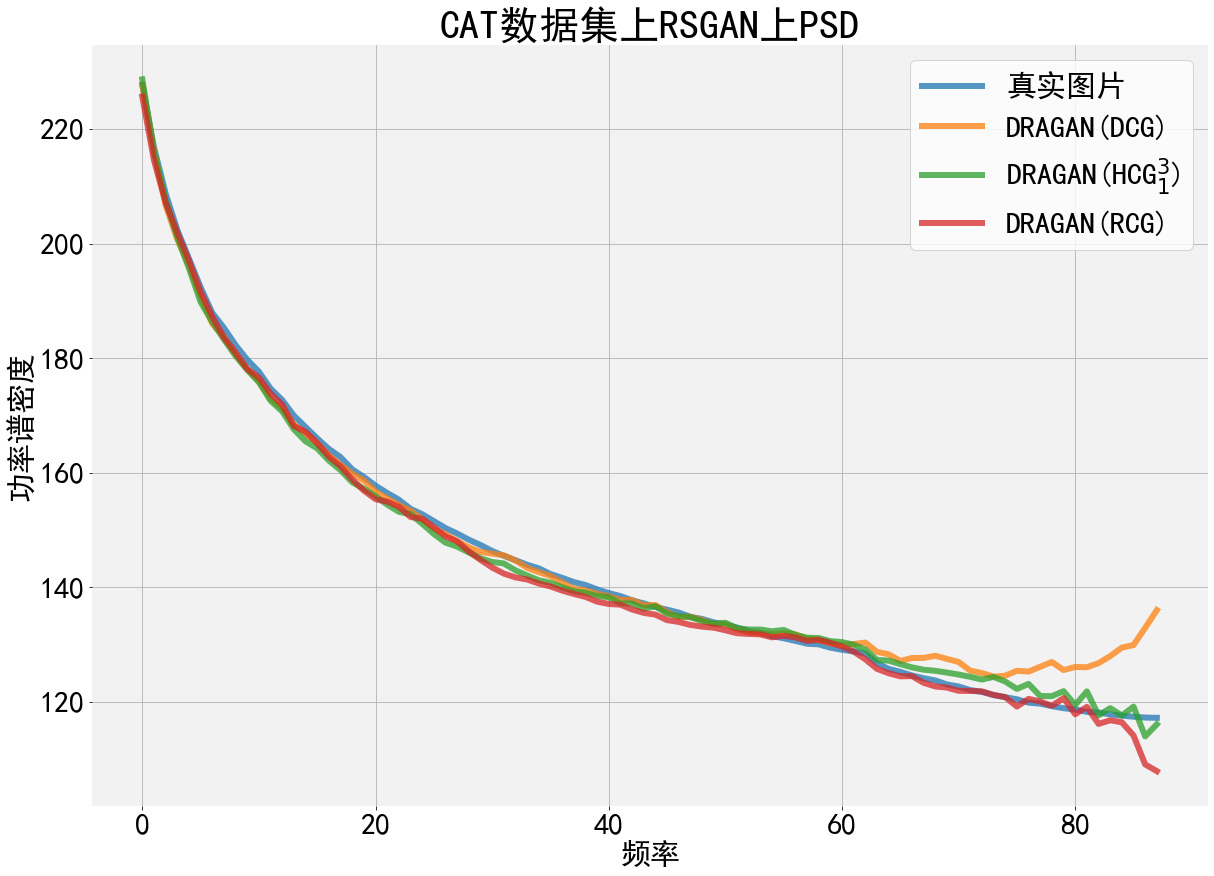

In [7]:
folderList = [
               '/data3/RelativisticGAN/CAT/cats_bigger_than_128x128/*.jpg',
                '/data3/RelativisticGAN/extra/RGAN_Deconv_CAT_10/*.png',
                '/data3/RelativisticGAN/extra/RGAN_Mixed_CAT_10/*.png',
                '/data3/RelativisticGAN/extra/RGAN_Resize_CAT_10/*.png'
             ]

labelList = [
            '真实图片',
            'DRAGAN(DCG)',
            'DRAGAN(HCG$^3_1$)',
            'DRAGAN(RCG)'
            ] 

bias = [0, 0, 1, -2]

RSGANPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 6400, 
                             savePath = "../毕业论文/RSGANPSD.pdf", title = "CAT数据集上RSGAN上PSD",
                             xlabel = "频率", ylabel = "功率谱密度", bias = bias, align = True)
RSGANPSD.draw()

In [8]:
folderList = [
               '/data3/RelativisticGAN/CAT/cats_bigger_than_128x128/*.jpg',
               '/data3/RelativisticGAN/extra/RaSGAN_Deconv_CAT_5/*.png',
               '/data3/RelativisticGAN/extra/RaSGAN_Mixed_CAT_6/*.png',
               '/data3/RelativisticGAN/extra/RaSGAN_Resize_CAT_6/*.png'
             ]

labelList = [
            '真实图片',
            'DRAGAN(DCG)',
            'DRAGAN(HCG$^3_1$)',
            'DRAGAN(RCG)'
            ] 

bias = [0, 3, -1, -5]

RaSGANPSD = dataset_draw(folderList = folderList, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 6400, 
                             savePath = "../毕业论文/RaSGANPSD.pdf", title = "CAT数据集上RaSGAN上PSD",
                             xlabel = "频率", ylabel = "功率谱密度", bias = bias)
RaSGANPSD.draw()

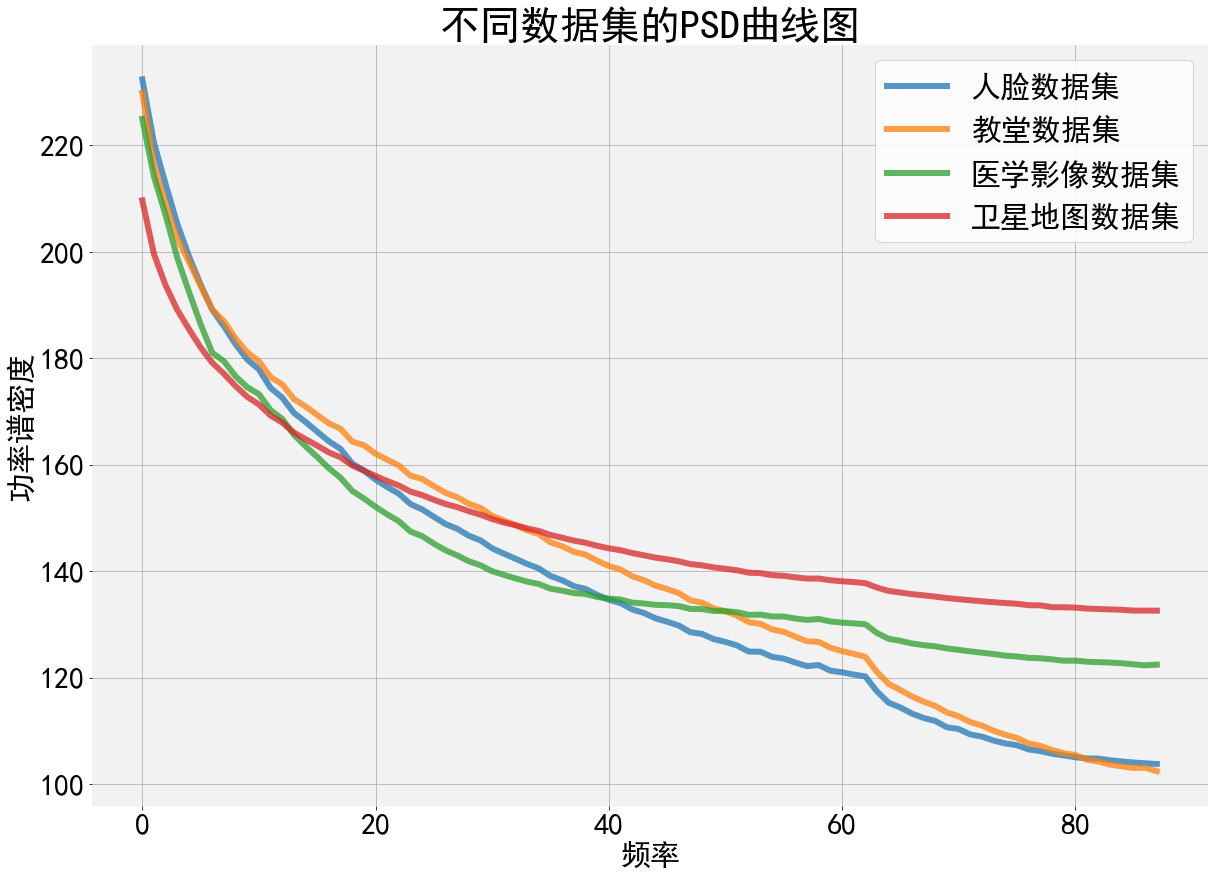

In [9]:
folder_list = ['/data0/cly/spectralGan/GAN-collections/data/celeba/celeba128/*png',
                    '/data0/cly/spectralGan/GAN-collections/data/lsun/church_outdoor128/*png',
                    '/data0/cly/spectralGan/GAN-collections/data/chest_xray/chest_xray128/*png',
                    '/data0/cly/spectralGan/GAN-collections/data/resize/*png'
                    ]

labelList = ['人脸数据集', '教堂数据集', '医学影像数据集', '卫星地图数据集'] 

DatasetPSD = dataset_draw(folderList = folder_list, labelList = labelList, inputSize = 128, outputSize = 88, maxIter = 1000, 
                             savePath = "../毕业论文/不同数据集的PSD曲线图.pdf", title = "不同数据集的PSD曲线图",
                             xlabel = "频率", ylabel = "功率谱密度")
DatasetPSD.draw()

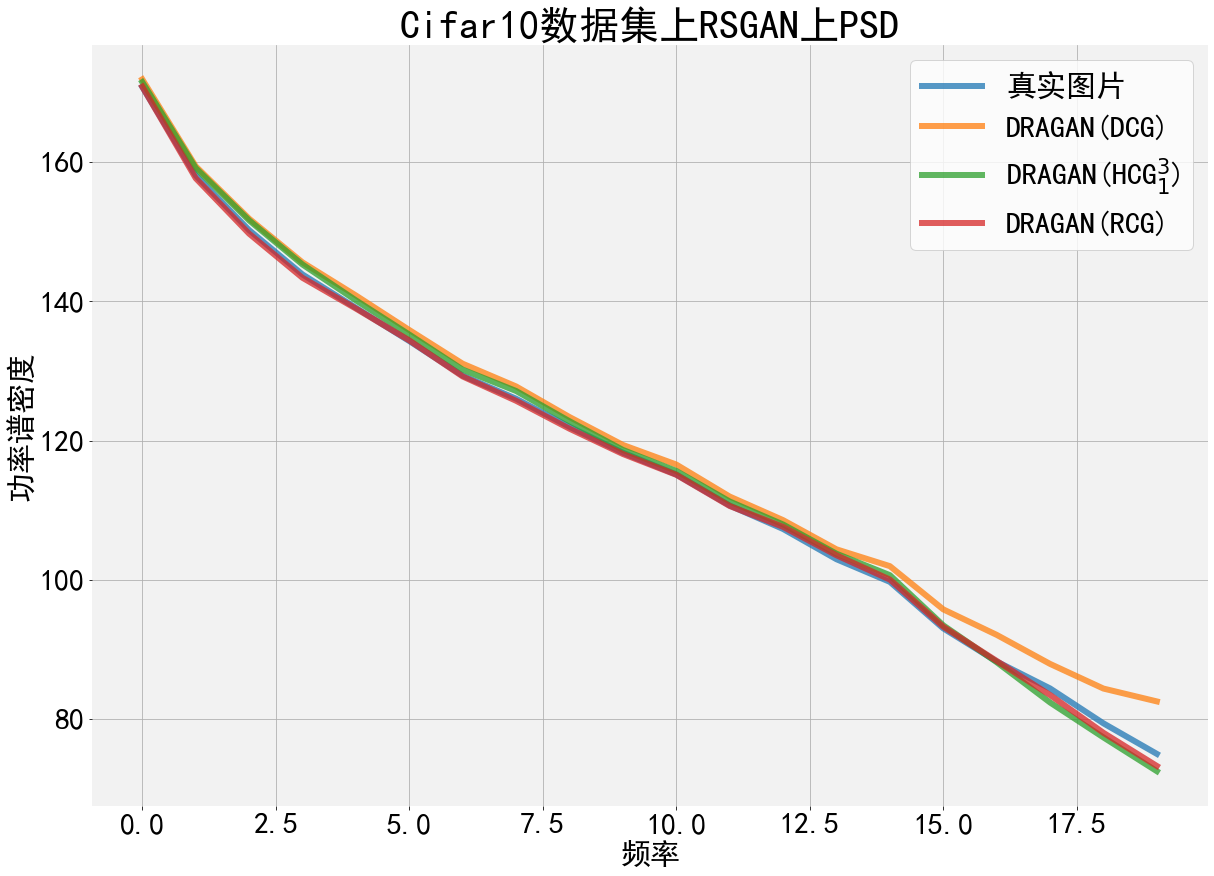

In [9]:
folder_list = ['/data0/cly/spectralGan/GAN-collections/data/cifar10/cifar1032/*.png',
                '/data3/RelativisticGAN/extra/RSGAN_Deconv_CIFAR10_1/*.png',
                '/data3/RelativisticGAN/extra/RSGAN_Mixed_CIFAR10_1/*.png',
                '/data3/RelativisticGAN/extra/RSGAN_Resize_CIFAR10_1/*.png'
                            ]

label_list = ['真实图片',
            'DRAGAN(DCG)',
            'DRAGAN(HCG$^3_1$)',
            'DRAGAN(RCG)']    

CifarPSD1 = dataset_draw(folderList = folder_list, labelList = label_list, inputSize = 32, outputSize = 20, maxIter = 5000, 
                             savePath = "../毕业论文/Cifar10数据集上RSGAN上PSD.pdf", title = "Cifar10数据集上RSGAN上PSD",
                             xlabel = "频率", ylabel = "功率谱密度", bias = [-2, 3, 0, 0])
CifarPSD1.draw()

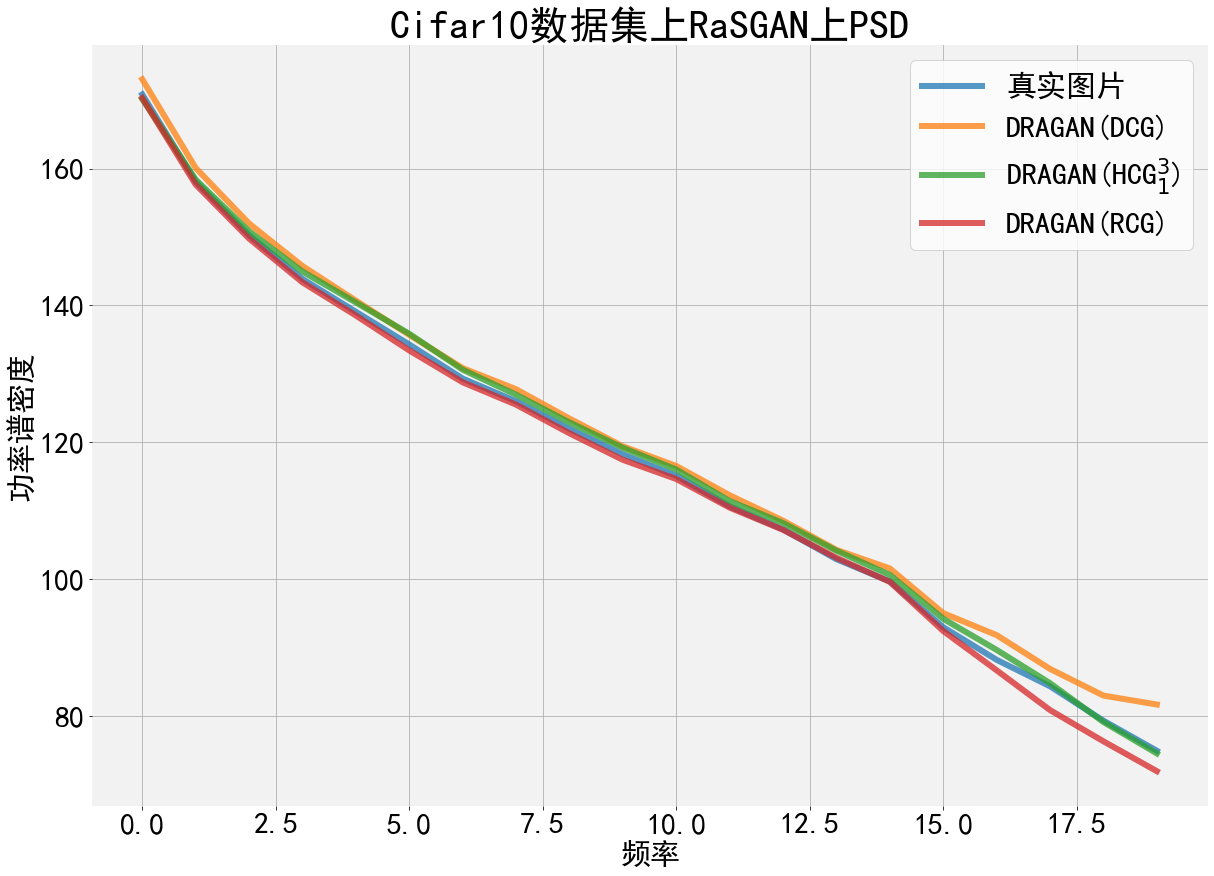

In [8]:
folder_list = ['/data0/cly/spectralGan/GAN-collections/data/cifar10/cifar1032/*.png',
                '/data3/RelativisticGAN/extra/RaSGAN_Deconv_CIFAR10_1/*.png',
                '/data3/RelativisticGAN/extra/RaSGAN_Resize_CIFAR10_1/*.png',
                '/data3/RelativisticGAN/extra/RaSGAN_Mixed_CIFAR10_1/*.png'
                            ]

label_list = ['真实图片',
            'DRAGAN(DCG)',
            'DRAGAN(HCG$^3_1$)',
            'DRAGAN(RCG)']    

CifarPSD2 = dataset_draw(folderList = folder_list, labelList = label_list, inputSize = 32, outputSize = 20, maxIter = 5000, 
                             savePath = "../毕业论文/Cifar10数据集上RaSGAN上PSD.pdf", title = "Cifar10数据集上RaSGAN上PSD",
                             xlabel = "频率", ylabel = "功率谱密度", bias = [-2, 3, 0, -1])
CifarPSD2.draw()

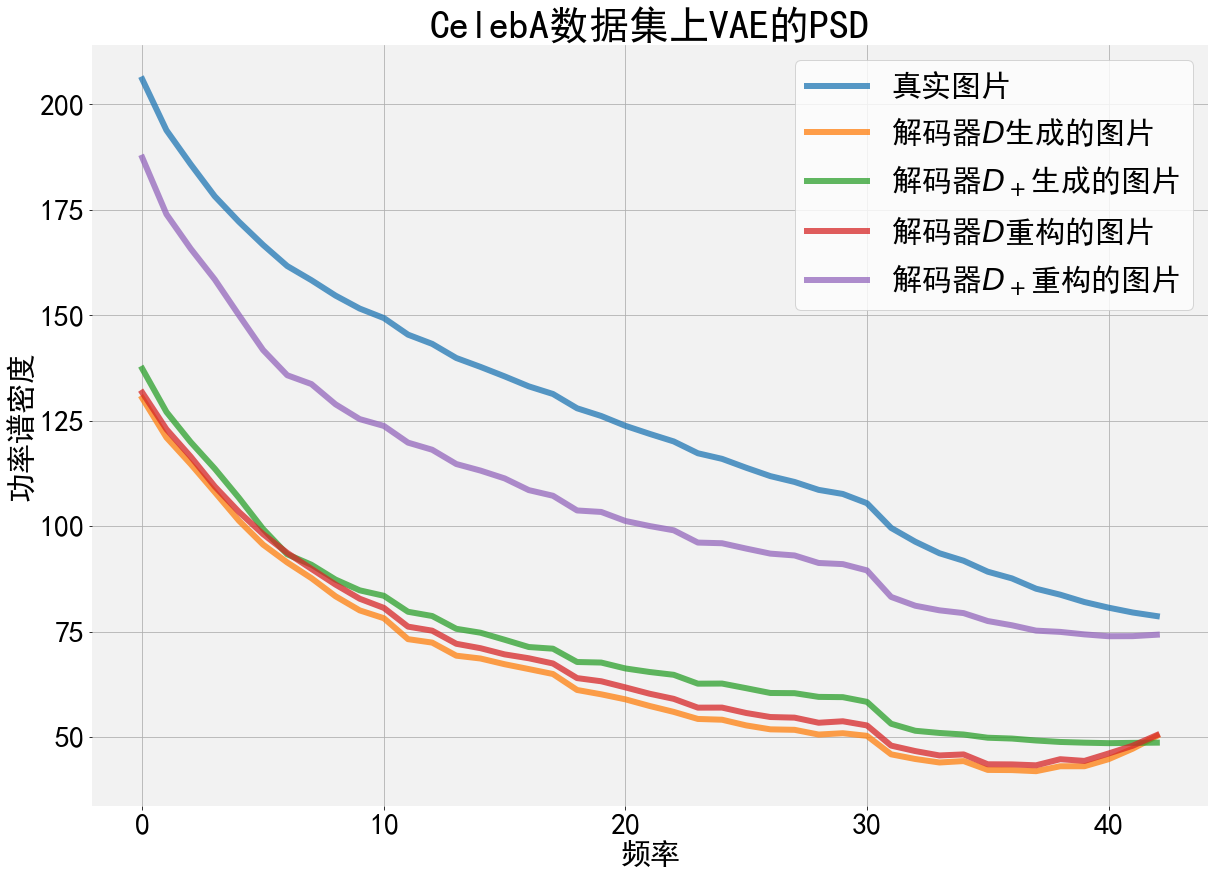

In [9]:
folderlist1 =   ['../data/celeba/celeba64/*',
                '/data0/cly/spectralGan/VAE/results_gen_deconv/*.png',
                '/data0/cly/spectralGan/VAE/results_gen_up1/*.png',
                '/data0/cly/spectralGan/VAE/results_recon_deconv/*.png',
                '/data0/cly/spectralGan/VAE/results_recon_up1/*.png'
                ]

labelList = ["真实图片", "解码器$D$生成的图片", "解码器$D_+$生成的图片", "解码器$D$重构的图片", "解码器$D_+$重构的图片"]

CelebAPSD = dataset_draw(folderList = folderlist1, labelList = labelList, inputSize = 64, outputSize = 43, maxIter = 4000, 
                             savePath = "../毕业论文/VAEPSD.pdf", title = "CelebA数据集上VAE的PSD",
                             xlabel = "频率", ylabel = "功率谱密度", bias = [1, 0, 7, 0, 2])


CelebAPSD.draw()